In [15]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [16]:
import requests
import os
from torch_geometric.data import Dataset
import torch

class HW3Dataset(Dataset):
    url = 'https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EUHUDSoVnitIrEA6ALsAK1QBpphP5jX3OmGyZAgnbUFo0A?download=1'

    def __init__(self, root, transform=None, pre_transform=None):
        super(HW3Dataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        file_url = self.url.replace(' ', '%20')
        response = requests.get(file_url)

        if response.status_code != 200:
            raise Exception(f"Failed to download the file, status code: {response.status_code}")

        with open(os.path.join(self.raw_dir, self.raw_file_names[0]), 'wb') as f:
            f.write(response.content)

    def process(self):
        raw_path = os.path.join(self.raw_dir, self.raw_file_names[0])
        data = torch.load(raw_path)
        torch.save(data, self.processed_paths[0])

    def len(self):
        return 1

    def get(self, idx):
        return torch.load(self.processed_paths[0])


In [ ]:
from torch_geometric.transforms import NormalizeFeatures

dataset = HW3Dataset(root='data/hw3/')

print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.



## Trying MLP

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=128, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=40, bias=True)
)


In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask].squeeze())  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)
      test_correct = pred[data.val_mask] == data.y[data.val_mask].squeeze()  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_correct.shape[0])  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 100):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 3.6978
Epoch: 002, Loss: 3.6388
Epoch: 003, Loss: 3.5777
Epoch: 004, Loss: 3.5091
Epoch: 005, Loss: 3.4381
Epoch: 006, Loss: 3.3695
Epoch: 007, Loss: 3.3162
Epoch: 008, Loss: 3.2747
Epoch: 009, Loss: 3.2448
Epoch: 010, Loss: 3.2163
Epoch: 011, Loss: 3.1871
Epoch: 012, Loss: 3.1627
Epoch: 013, Loss: 3.1372
Epoch: 014, Loss: 3.1153
Epoch: 015, Loss: 3.0937
Epoch: 016, Loss: 3.0794
Epoch: 017, Loss: 3.0628
Epoch: 018, Loss: 3.0479
Epoch: 019, Loss: 3.0339
Epoch: 020, Loss: 3.0177
Epoch: 021, Loss: 3.0048
Epoch: 022, Loss: 2.9898
Epoch: 023, Loss: 2.9774
Epoch: 024, Loss: 2.9647
Epoch: 025, Loss: 2.9558
Epoch: 026, Loss: 2.9456
Epoch: 027, Loss: 2.9313
Epoch: 028, Loss: 2.9183
Epoch: 029, Loss: 2.9057
Epoch: 030, Loss: 2.8932
Epoch: 031, Loss: 2.8831
Epoch: 032, Loss: 2.8733
Epoch: 033, Loss: 2.8601
Epoch: 034, Loss: 2.8493
Epoch: 035, Loss: 2.8380
Epoch: 036, Loss: 2.8282
Epoch: 037, Loss: 2.8162
Epoch: 038, Loss: 2.8054
Epoch: 039, Loss: 2.7970
Epoch: 040, Loss: 2.7847


In [12]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.3880


## Trying GCN



In [6]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 8)
        self.conv4 = GCNConv(8, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x,edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)

        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(128, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 8)
  (conv4): GCNConv(8, 40)
)


Visualization of the node embeddings of our **untrained** GCN network.

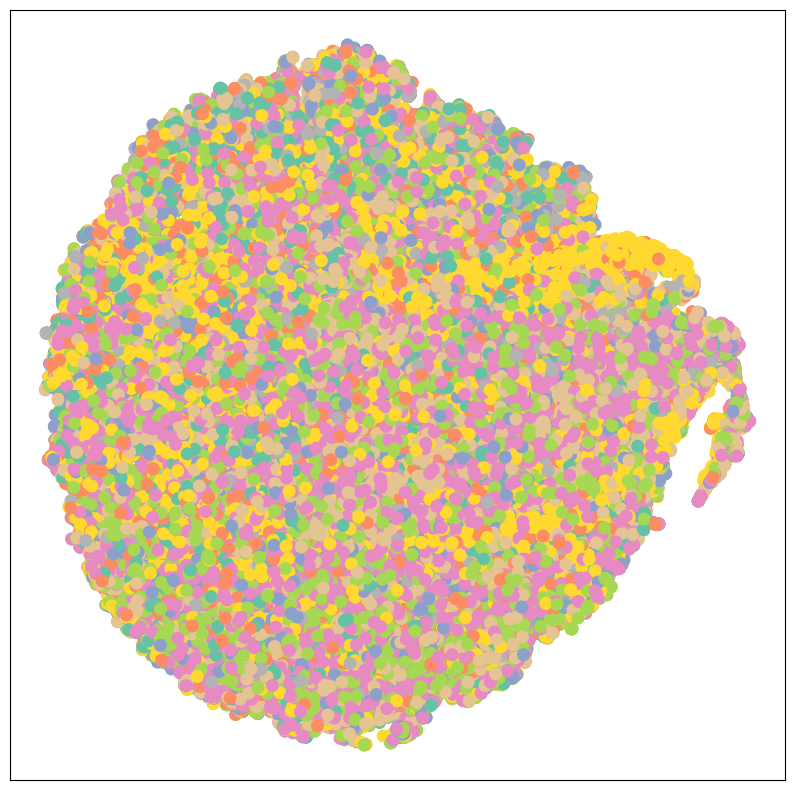

In [9]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [13]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask].squeeze())  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.val_mask] == data.y[data.val_mask].squeeze()  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_correct.shape[0])  # Derive ratio of correct predictions.
      return test_acc



for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 3.7595
Epoch: 002, Loss: 3.5490
Epoch: 003, Loss: 3.4537
Epoch: 004, Loss: 3.3806
Epoch: 005, Loss: 3.3120
Epoch: 006, Loss: 3.2250
Epoch: 007, Loss: 3.1641
Epoch: 008, Loss: 3.0982
Epoch: 009, Loss: 3.0459
Epoch: 010, Loss: 2.9934
Epoch: 011, Loss: 2.9533
Epoch: 012, Loss: 2.9209
Epoch: 013, Loss: 2.8773
Epoch: 014, Loss: 2.8443
Epoch: 015, Loss: 2.8205
Epoch: 016, Loss: 2.7884
Epoch: 017, Loss: 2.7654
Epoch: 018, Loss: 2.7412
Epoch: 019, Loss: 2.7207
Epoch: 020, Loss: 2.6983
Epoch: 021, Loss: 2.6721
Epoch: 022, Loss: 2.6589
Epoch: 023, Loss: 2.6297
Epoch: 024, Loss: 2.6149
Epoch: 025, Loss: 2.5916
Epoch: 026, Loss: 2.5738
Epoch: 027, Loss: 2.5528
Epoch: 028, Loss: 2.5381
Epoch: 029, Loss: 2.5213
Epoch: 030, Loss: 2.4991
Epoch: 031, Loss: 2.4796
Epoch: 032, Loss: 2.4669
Epoch: 033, Loss: 2.4503
Epoch: 034, Loss: 2.4361
Epoch: 035, Loss: 2.4179
Epoch: 036, Loss: 2.3991
Epoch: 037, Loss: 2.3930
Epoch: 038, Loss: 2.3715
Epoch: 039, Loss: 2.3577
Epoch: 040, Loss: 2.3435


In [96]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5035


Visualization of the node embeddings of our **trained** GCN network.

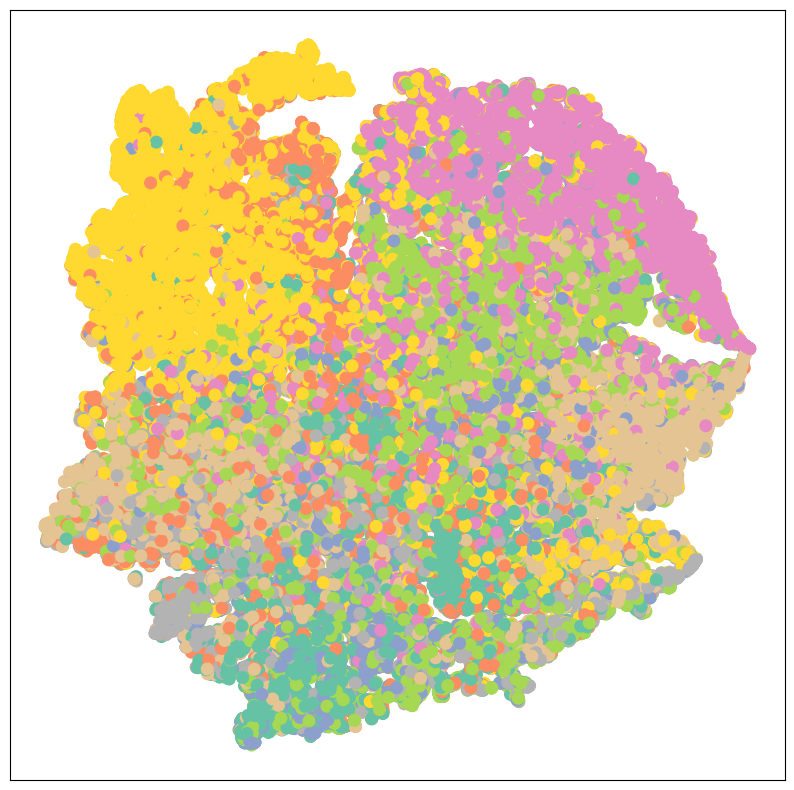

In [14]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Trying GAT

In [ ]:
from torch_geometric.nn import GATConv
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATModel(nn.Module):
    def __init__(self, num_features, num_classes, num_layers, hidden_dim, num_heads):
        super(GATModel, self).__init__()

        self.conv1 = GATConv(dataset.num_features, hidden_dim, heads=num_heads)
        self.convs = nn.ModuleList([
            GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
            for _ in range(num_layers - 1)
        ])
        self.lin = nn.Linear(hidden_dim * num_heads, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))

        for conv in self.convs:
            x = F.dropout(x, p=0.6, training=self.training)
            x = F.elu(conv(x, edge_index))

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = GATModel(num_features=dataset.num_features, num_classes=dataset.num_classes,
                 num_layers=2, hidden_dim=64, num_heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask].squeeze())  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[data.val_mask] == data.y[data.val_mask].squeeze()  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(correct.shape[0])  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    #test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

GATModel(
  (conv1): GATConv(128, 64, heads=40)
  (convs): ModuleList(
    (0): GATConv(2560, 64, heads=40)
  )
  (lin): Linear(in_features=2560, out_features=40, bias=True)
)
